In [1]:
import numpy as np
import dedalus.public as d3

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import cmocean.cm as cmo

plt.style.use('/mnt/c/Ryan_Data/Python_Tool/ryan_mplstyle.mplstyle')

In [2]:
# Numerics Parameters
Lz = 1
Nz = 128

dtype = np.complex128

# Bases
Lzt, Lzb = 0, -Lz

coords = d3.CartesianCoordinates('z')
dist = d3.Distributor(coords, dtype=dtype)
zbasis = d3.Chebyshev(coords['z'], size=Nz, bounds=(Lzb, Lzt))

In [3]:
# Fields
omega = dist.Field()

q = dist.Field(name='q', bases=zbasis )
bt = dist.Field(name='bt' )
bb = dist.Field(name='bb' )

P0 = dist.Field(name='P0', bases=zbasis )

tau_P0 = dist.Field()
tau_P0t = dist.Field( )
tau_P0b = dist.Field( )

kx = dist.Field(name='kx')
ky = dist.Field(name='ky')
omega = dist.Field()

# Substitutions
dx = lambda A: 1j*kx*A
dy = lambda A: 1j*ky*A
dz = lambda A: d3.Differentiate(A, coords['z'])
dt = lambda A: -1j*omega*A

z = dist.local_grids(zbasis)

lift_basis = zbasis.derivative_basis(2)
lift = lambda A, n: d3.Lift(A, lift_basis, n)

u = -dy(P0)
v =  dx(P0)

ut = u(z=Lzt); vt = v(z=Lzt); 
ub = u(z=Lzb); vb = v(z=Lzb); 

lap = lambda A: dx(dx(A))+dy(dy(A))+dz(dz(A))

In [4]:
# Problem
problem = d3.EVP([P0, tau_P0t, tau_P0b, \
                  bt, bb \
                  ], eigenvalue=omega, namespace=locals())

problem.add_equation("lap(P0) + lift(tau_P0t,-1) + lift(tau_P0b,-2) = 0")
problem.add_equation("dz(P0)(z=Lzt) - bt = 0"); problem.add_equation("dz(P0)(z=Lzb) - bb = 0")

problem.add_equation("dt(bt) + Lzt*dx(bt)-vt = 0")
problem.add_equation("dt(bb) + Lzb*dx(bb)-vb = 0")

{'LHS': Add(Add(Mul(Mul((-0-1j), <Field 140638891206992>), <Field 140638891211024>), Mul(-1, Mul(Mul(1j, <Field 140638891210688>), <Field 140638891211024>))), Mul(-1, interp(Mul(Mul(1j, <Field 140638891210688>), <Field 140638891211120>), z=-1))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'M': Mul((-0-1j), <Field 140638891211024>),
 'L': Add(Mul(-1, Mul(Mul(1j, <Field 140638891210688>), <Field 140638891211024>)), Mul(-1, interp(Mul(Mul(1j, <Field 140638891210688>), <Field 140638891211120>), z=-1))),
 'domain': <dedalus.core.domain.Domain at 0x7fe90b26f820>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [5]:
# Solver
k_ary = np.arange(0.01,4,0.03)
grow_ary = np.empty([k_ary.size])
c_ary_1 = np.empty([k_ary.size], dtype=complex)
c_ary_2 = np.empty([k_ary.size], dtype=complex)

for ix in range(k_ary.size):
    kx['g'] = k_ary[ix]; ky['g'] = 0

    solver = problem.build_solver()
    solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
    evals = solver.eigenvalues
    # print(evals.shape)

    e_loc = np.argmax(np.imag(evals))
    grow_ary[ix] = np.imag(evals[e_loc])
    
    if abs(np.imag(evals[e_loc])) > 1e-15:
        c_ary_1[ix] = evals[e_loc]/k_ary[ix]
        c_ary_2[ix] = evals[e_loc]/k_ary[ix]
    else:
        c_ary_1[ix] = np.min(evals[evals<np.inf])/k_ary[ix]
        c_ary_2[ix] = np.max(evals[evals<np.inf])/k_ary[ix]

2023-10-25 10:26:09,705 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+01/s
2023-10-25 10:26:09,749 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+01/s
2023-10-25 10:26:09,787 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.8e+01/s
2023-10-25 10:26:09,825 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+01/s
2023-10-25 10:26:09,862 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.2e+01/s
2023-10-25 10:26:09,898 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.6e+01/s
2023-10-25 10:26:09,934 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.7e+01/s
2023-10-25 10:26:09,972 subsystems 0/1 INFO :: Building subproblem matrices 

In [6]:
k_max = k_ary[np.argmax(grow_ary)]

kx['g'] = k_max; ky['g'] = 0
# kx['g'] = 3.5; ky['g'] = 0

solver = problem.build_solver()
solver.solve_dense(solver.subproblems[0], rebuild_matrices=True)
evals = solver.eigenvalues
print(evals)

loc_grow = np.argmax(np.imag(evals))

2023-10-25 10:26:14,064 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.5e+01/s
[ inf+0.j          inf+0.j          inf+0.j         -0.8+0.30980958j
 -0.8-0.30980958j  inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+0.j          inf+0.j          inf+0.j          inf+0.j
  inf+

In [7]:
solver.set_state(loc_grow,0)

P0_evec = solver.state[0]['g'] # index 0 because P0 is the first element of the d3.EVP statement

/tmp/ipykernel_4278/213282465.py:18: UserWarning: The label '__ok__' of <matplotlib.lines.Line2D object at 0x7fe902ff4760> starts with '_'. It is thus excluded from the legend.
  plt.legend(["$-C_r$",'__ok__',"$C_i$"])


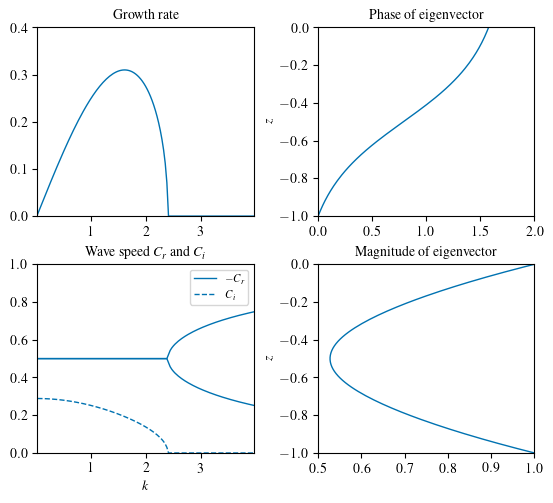

In [8]:
# plot
fig=plt.figure(figsize=(5.5,5))

plt.subplot(2,2,1)
plt.plot(k_ary,grow_ary)
plt.ylim(0,0.4)

k_max = k_ary[np.argmax(grow_ary)]
plt.title("Growth rate")
# plt.xlabel("$k$")

plt.subplot(2,2,3)
plt.plot(k_ary,-np.real(c_ary_1),color=(0,0.4453125,0.6953125))
plt.plot(k_ary,-np.real(c_ary_2),color=(0,0.4453125,0.6953125))

plt.plot(k_ary,np.imag(c_ary_1),'--')

plt.legend(["$-C_r$",'__ok__',"$C_i$"])
plt.title("Wave speed $C_r$ and $C_i$")
plt.ylim(0,1)
plt.xlabel("$k$")

plt.subplot(2,2,2)
plt.plot(np.angle(P0_evec)-np.angle(P0_evec[0]),z[0].ravel())
plt.xlim(0,2)
plt.title("Phase of eigenvector")
plt.ylim(-1,0)
plt.ylabel("$z$")

plt.subplot(2,2,4)
plt.plot(np.abs(P0_evec)/np.abs(P0_evec[0]),z[0].ravel())
plt.xlim(0.5,1)
plt.title("Magnitude of eigenvector")
plt.ylim(-1,0)
plt.ylabel("$z$")

fig.tight_layout(pad=0.6)
plt.savefig("figs/Eady_matchvallis.pdf", bbox_inches='tight')
plt.show()

In [9]:
b = dist.Field(bases=zbasis )
v = dist.Field(bases=zbasis )

In [10]:
# Problem
problem_morefields = d3.LBVP([v, b], namespace=locals())

problem_morefields.add_equation("v = dx(P0)")
problem_morefields.add_equation("b = dz(P0)")

{'LHS': <Field 140638755969568>,
 'RHS': Diff(<Field 140638891211120>),
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'L': Convert(<Field 140638755969568>),
 'F': Diff(<Field 140638891211120>),
 'domain': <dedalus.core.domain.Domain at 0x7fe90b26f700>,
 'matrix_dependence': array([ True]),
 'matrix_coupling': array([ True])}

In [11]:
P0['g'] = P0_evec

In [12]:
# Solver
solver_morefields = problem_morefields.build_solver()
solver_morefields.solve()

2023-10-25 10:26:15,555 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


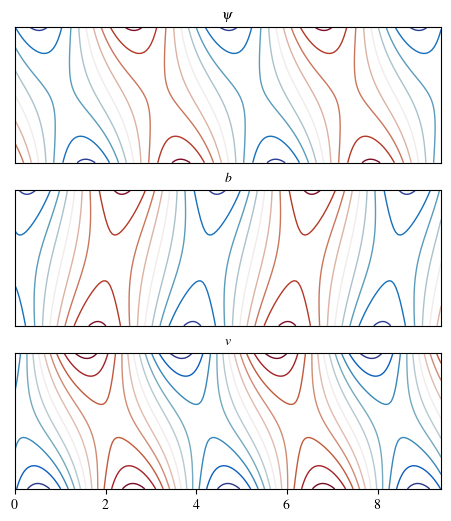

In [14]:
x = np.arange(0,3*np.pi,0.05)
phs_corr = np.exp(1j*1.5*x)

fig=plt.figure(figsize=(5.5,6))

plt.subplot(3,1,1)
P0eig_mat = np.outer(P0['g'],phs_corr)
plt.contour(x,z[0].ravel(),P0eig_mat.real, 10, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.xticks([]); plt.yticks([])
plt.title("$\psi$")

plt.subplot(3,1,2)
beig_mat = np.outer(b['g'],phs_corr)
plt.contour(x,z[0].ravel(),beig_mat.real, 10, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.xticks([]); plt.yticks([])
plt.title("$b$")

plt.subplot(3,1,3)
veig_mat = np.outer(v['g'],phs_corr)
plt.contour(x,z[0].ravel(),veig_mat.real, 10, cmap=cmo.balance, norm=colors.CenteredNorm())
plt.yticks([])
plt.title("$v$")

plt.savefig("figs/Eady_profile.pdf", bbox_inches='tight')
plt.show()